In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [2]:
nturn = 1024

In [3]:
sigma_K = 2.0e-3

In [4]:
def getChromaticTuneImpact(deco,tmp,nturn=1024):
    nHalfSample = 8
    nTotalSample = 2*nHalfSample +1
    
    beam,lattice = impact.readInputFile('test_'+deco+'.in')
    beam.nCore_y=1
    beam.nCore_z=1
    beam.n_particles = 1

    ke = beam.kinetic_energy
    mass = beam.mass
    freq = beam.frequency

    g = ke/mass+1.0
    bg = np.sqrt(g**2-1.0)
    b = bg/g

    sigma_delta = sigma_K*g/(g+1)
    sigma_delta
    
    cleanLat = impact.clearLattice(lattice)
    cleanLat = impact.addHardEdgeQuad(lattice)
    for item in cleanLat:
        if item.type == 'RFkick':
            item.vmax = 0.0
        if item.type == 'nonlinear_insert':
            NLfoward = item
            NLfoward.n_sckick = 2
            NLfoward.n_map = 45
        if 'length' in item:
            item.n_sckick = int(np.ceil(item.length*50))
            item.n_map = 1

    Deltas = np.linspace(-3*sigma_delta,3*sigma_delta,nTotalSample)
    Corbit = [0]*nTotalSample
    Loss = [0]*nTotalSample
    xTune = [0]*nTotalSample
    yTune = [0]*nTotalSample
    dx = np.zeros(6)
    dx[1] = 1.0e-6
    dy = np.zeros(6)
    dy[3] = 1.0e-6


    delta = 0 
    pData_init = np.zeros(4)
    result_x,result_loss = impact.util.get_closed_orbit(beam,cleanLat,np.zeros(4),delta)
    pData_init = np.zeros(6)
    pData_init[:4] = result_x
    pData_init[ 5] = delta*(g+1)/g*ke
    tune_x, amp = impact.util.get_tune(beam,lattice,pData_init+dx,direction='x',nturn=nturn, order=3)
    tune_y, amp = impact.util.get_tune(beam,lattice,pData_init+dy,direction='y',nturn=nturn, order=3)
    Corbit[nHalfSample] = result_x
    Loss  [nHalfSample] = result_loss
    xTune [nHalfSample] = tune_x
    yTune [nHalfSample] = tune_y
    print(result_x,result_loss,tune_x,tune_y)

    result_x = np.zeros(4)
    i=0    
    for delta in [(f+1.0)*3.0/nHalfSample*sigma_delta for f in range(nHalfSample)]:
        pData_init = result_x
        result_x,result_loss = impact.util.get_closed_orbit(beam,cleanLat,result_x,delta,delta0=delta-sigma_delta)
        pData_init = np.zeros(6)
        pData_init[:4] = result_x
        pData_init[ 5] = delta*(g+1)/g*ke
        tune_x, amp = impact.util.get_tune(beam,lattice,pData_init+dx,direction='x',nturn=nturn, order=3)
        tune_y, amp = impact.util.get_tune(beam,lattice,pData_init+dy,direction='y',nturn=nturn, order=3)
        Corbit[nHalfSample+1+i] = result_x
        Loss  [nHalfSample+1+i] = result_loss
        xTune [nHalfSample+1+i] = tune_x
        yTune [nHalfSample+1+i] = tune_y
        print(result_x,result_loss,tune_x,tune_y)
        i=i+1

    result_x = np.zeros(4)
    i=0    
    for delta in [-(f+1.0)*3.0/nHalfSample*sigma_delta for f in range(nHalfSample)]:
        pData_init = result_x
        result_x,result_loss = impact.util.get_closed_orbit(beam,cleanLat,result_x,delta,delta0=delta+sigma_delta)
        pData_init = np.zeros(6)
        pData_init[:4] = result_x
        pData_init[ 5] = delta*(g+1)/g*ke
        tune_x, amp = impact.util.get_tune(beam,lattice,pData_init+dx,direction='x',nturn=nturn, order=3)
        tune_y, amp = impact.util.get_tune(beam,lattice,pData_init+dy,direction='y',nturn=nturn, order=3)
        Corbit[nHalfSample-1-i] = result_x
        Loss  [nHalfSample-1-i] = result_loss
        xTune [nHalfSample-1-i] = tune_x
        yTune [nHalfSample-1-i] = tune_y
        print(result_x,result_loss,tune_x,tune_y)
        i=i+1
    
    tmp['co']=copy(Corbit)
    tmp['loss']=copy(Loss)
    tmp['nux']=copy(xTune)
    tmp['nuy']=copy(yTune)
    
    tmp['MLI_nux1'] = tmp['MLI_nux0'] + Deltas*tmp['MLI_xi1x']
    tmp['MLI_nuy1'] = tmp['MLI_nuy0'] + Deltas*tmp['MLI_xi1y']
    tmp['MLI_nux2'] = tmp['MLI_nux0'] + Deltas*tmp['MLI_xi1x'] +  Deltas*Deltas*tmp['MLI_xi2x']
    tmp['MLI_nuy2'] = tmp['MLI_nuy0'] + Deltas*tmp['MLI_xi1y'] +  Deltas*Deltas*tmp['MLI_xi2y']
    
    return Deltas

In [5]:
Deco = ['iota_v8_4_SextOff_NLoff','iota_v8_4_SextOff_NLon',
        'iota_v8_4_SextOn_NLoff','iota_v8_4_SextOn_NLon',
        'iota_v8_4_SextGoodDA_NLoff','iota_v8_4_SextGoodDA_NLon']
data = {}

# SextOff

In [6]:
deco = 'iota_v8_4_SextOff_NLon'
data[deco] = {}
tmp = data[deco]
tmp['MLI_nux0'] = 0.402493674
tmp['MLI_xi1x'] = -1.08154496e1
tmp['MLI_xi2x'] =  3.58145831e2
tmp['MLI_nuy0'] = 0.134164070
tmp['MLI_xi1y'] = -1.18019795e1
tmp['MLI_xi2y'] = -1.77252703e2

Deltas = getChromaticTuneImpact(deco,tmp,nturn)

reading ImpactZ input file (test_iota_v8_4_SextOff_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
[0. 0. 0. 0.] 0.0 0.40240690715402744 0.1339706556491505
[-7.44014623e-05  8.46622096e-07  3.82237243e-05  1.87646078e-05] 1.6999579875083918e-10 0.3984452548452792 0.12981721346393904
[-7.81215354e-05  8.46622096e-07  3.82237243e-05  1.87646078e-05] 2.2622030786235237e-08 0.39451101351564044 0.1250905944214656
[-8.20276122e-05  8.46622096e-07  3.82237243e-05  1.87646078e-05] 9.390337895961689e-08 0.390606024992101 0.12034390218277169
[-8.61289928e-05  8.46622096e-07 

Text(0,0.5,'$\\nu$')

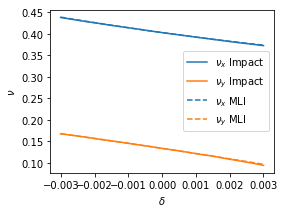

In [7]:
plt.figure(figsize=(4,3))
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')

In [8]:
deco = 'iota_v8_4_SextOff_NLoff'
data[deco] = {}
tmp = data[deco]
tmp['MLI_nux0'] =  0.300001220
tmp['MLI_xi1x'] = -1.08585913e1
tmp['MLI_xi2x'] =  3.12123923e2
tmp['MLI_nuy0'] =  0.299999995
tmp['MLI_xi1y'] = -7.22113747
tmp['MLI_xi2y'] =  1.98869293e2

Deltas = getChromaticTuneImpact(deco,tmp,nturn)

reading ImpactZ input file (test_iota_v8_4_SextOff_NLoff.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
[0. 0. 0. 0.] 0.0 0.29988836588223217 0.2998877979507727
[-7.51141841e-05  3.65574177e-06 -1.89835527e-06 -2.82175304e-06] 4.8787699351500634e-11 0.2959179783471437 0.29708719988963617
[-7.88698933e-05  3.65574177e-06 -1.89835527e-06 -2.82175304e-06] 2.250398702602594e-08 0.2919705298977892 0.2947937792546174
[-8.28133880e-05  3.65574177e-06 -1.89835527e-06 -2.82175304e-06] 9.247330875896564e-08 0.2880436520644562 0.29199591884205406
[-8.69540574e-05  3.65574177e-06 

Text(0,0.5,'$\\nu$')

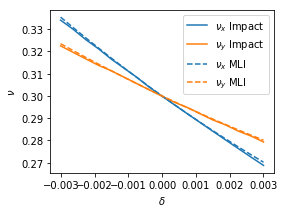

In [9]:
plt.figure(figsize=(4,3))
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')

# SextOn

In [10]:
deco = 'iota_v8_4_SextOn_NLon'
data[deco] = {}
tmp = data[deco]
tmp['MLI_nux0'] =  0.402493674
tmp['MLI_xi1x'] =  5.94101060
tmp['MLI_xi2x'] =  3.20855054e3
tmp['MLI_nuy0'] =  0.134164070
tmp['MLI_xi1y'] =  1.12553808e1
tmp['MLI_xi2y'] = -3.28732808e3

Deltas = getChromaticTuneImpact(deco,tmp,nturn)

reading ImpactZ input file (test_iota_v8_4_SextOn_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
[0. 0. 0. 0.] 0.0 0.40240690717241656 0.1339706546362532
[-6.77758452e-05  3.70946971e-06  2.10121066e-06  5.16374977e-07] 1.0546532047359846e-11 0.4051303602952196 0.13793519413649133
[-7.11646374e-05  3.70946971e-06  2.10121066e-06  5.16374977e-07] 9.862565327067394e-09 0.4080890130070419 0.14164257152590615
[-7.47228693e-05  3.70946971e-06  2.10121066e-06  5.16374977e-07] 2.8453740837942968e-08 0.41132567172853723 0.14464329723391225
[-7.84590128e-05  3.70946971e-06

Text(0,0.5,'$\\nu$')

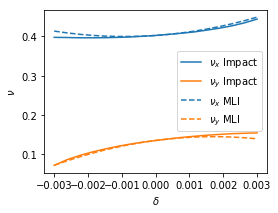

In [11]:
plt.figure(figsize=(4,3))
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')

In [12]:
deco = 'iota_v8_4_SextOn_NLoff'
data[deco] = {}
tmp = data[deco]
tmp['MLI_nux0'] =  0.300001220
tmp['MLI_xi1x'] =  4.36373201
tmp['MLI_xi2x'] =  1.93235086e3
tmp['MLI_nuy0'] =  0.299999995
tmp['MLI_xi1y'] = -1.52718760
tmp['MLI_xi2y'] = -4.83455563e2

Deltas = getChromaticTuneImpact(deco,tmp,nturn)

reading ImpactZ input file (test_iota_v8_4_SextOn_NLoff.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
[0. 0. 0. 0.] 0.0 0.299888365907349 0.2998877980072298
[-6.55210992e-05  2.01859709e-06 -8.91871939e-06 -8.39909150e-06] 2.90717168613972e-10 0.3017657241639181 0.2996012977082526
[-6.87971541e-05  2.01859709e-06 -8.91871939e-06 -8.39909150e-06] 1.0693973947041359e-08 0.3037633256903502 0.29877834141394005
[-7.22370118e-05  2.01859709e-06 -8.91871939e-06 -8.39909150e-06] 2.92469897968189e-08 0.3064160312979174 0.29788849942799245
[-7.58488624e-05  2.01859709e-06 -8.91

Text(0,0.5,'$\\nu$')

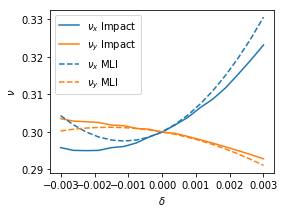

In [13]:
plt.figure(figsize=(4,3))
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')

# SextGoodDA

In [14]:
deco = 'iota_v8_4_SextGoodDA_NLon'
data[deco] = {}
tmp = data[deco]
tmp['MLI_nux0'] =  0.402493674
tmp['MLI_xi1x'] =  1.15111316
tmp['MLI_xi2x'] =  1.97935716e3
tmp['MLI_nuy0'] =  0.134164070
tmp['MLI_xi1y'] =  9.23762105
tmp['MLI_xi2y'] = -2.23386418e3

Deltas = getChromaticTuneImpact(deco,tmp,nturn)

reading ImpactZ input file (test_iota_v8_4_SextGoodDA_NLon.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
[0. 0. 0. 0.] 0.0 0.40240690716417404 0.13397065476905615
[-6.74316036e-05  1.95937511e-06  3.32767258e-06  2.38322478e-06] 7.688475887003986e-12 0.40321046102624725 0.1376020864687156
[-7.08031838e-05  1.95937511e-06  3.32767258e-06  2.38322478e-06] 1.3944080948755276e-08 0.4041353994966193 0.1405572694241533
[-7.43433430e-05  1.95937511e-06  3.32767258e-06  2.38322478e-06] 4.5090493729506163e-08 0.4052320466672564 0.14333855043172877
[-7.80605101e-05  1.95937511e

Text(0,0.5,'$\\nu$')

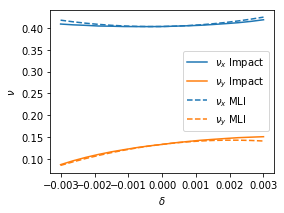

In [15]:
plt.figure(figsize=(4,3))
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')

In [16]:
deco = 'iota_v8_4_SextGoodDA_NLoff'
data[deco] = {}
tmp = data[deco]
tmp['MLI_nux0'] =  0.300001220
tmp['MLI_xi1x'] =  0.177650373
tmp['MLI_xi2x'] =  1.33690408e3
tmp['MLI_nuy0'] =  0.299999995
tmp['MLI_xi1y'] = -1.43543296
tmp['MLI_xi2y'] = -2.86570740e2

Deltas = getChromaticTuneImpact(deco,tmp,nturn)

reading ImpactZ input file (test_iota_v8_4_SextGoodDA_NLoff.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done
[0. 0. 0. 0.] 0.0 0.29988836590230394 0.29988779797916615
[-6.93461632e-05 -4.14971606e-07  6.21829269e-07  3.70334672e-06] 6.64737350020027e-11 0.29997435186879023 0.29963077340423694
[-7.28134713e-05 -4.14971606e-07  6.21829269e-07  3.70334672e-06] 1.2444960593079511e-08 0.30066533864001876 0.2988309068482029
[-7.64541449e-05 -4.14971606e-07  6.21829269e-07  3.70334672e-06] 4.1820087411148566e-08 0.30091343998810993 0.29800304469088656
[-8.02768521e-05 -4.149716

Text(0,0.5,'$\\nu$')

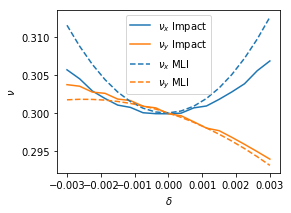

In [17]:
plt.figure(figsize=(4,3))
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')

# plot sum

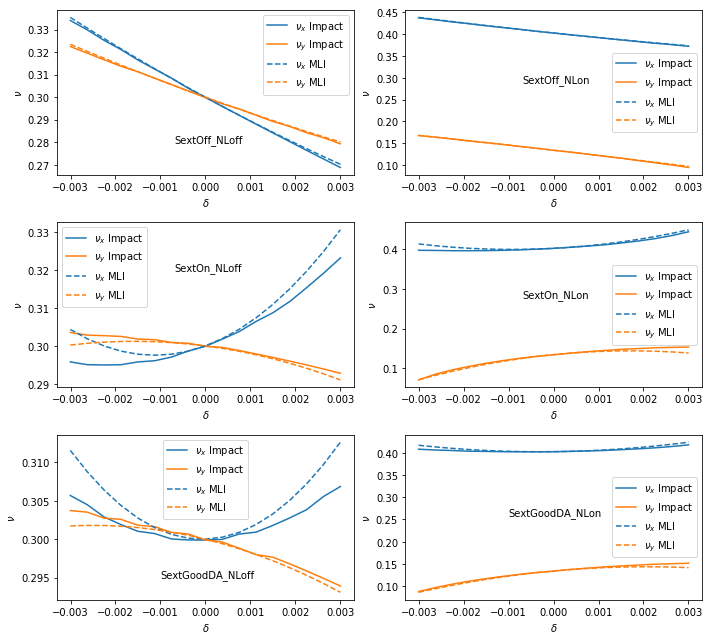

In [28]:
plt.figure(figsize=(10,9))
plt.subplot(3,2,1)
deco = 'iota_v8_4_SextOff_NLoff'
tmp = data[deco]
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')
plt.text(-0.0007,0.28,deco[10:])

plt.subplot(3,2,2)
deco = 'iota_v8_4_SextOff_NLon'
tmp = data[deco]
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')
plt.text(-0.0007,0.29,deco[10:])

plt.subplot(3,2,3)
deco = 'iota_v8_4_SextOn_NLoff'
tmp = data[deco]
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')
plt.text(-0.0007,0.32,deco[10:])

plt.subplot(3,2,4)
deco = 'iota_v8_4_SextOn_NLon'
tmp = data[deco]
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')
plt.text(-0.0007,0.28,deco[10:])

plt.subplot(3,2,5)
deco = 'iota_v8_4_SextGoodDA_NLoff'
tmp = data[deco]
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')
plt.text(-0.001,0.295,deco[10:])

plt.subplot(3,2,6)
deco = 'iota_v8_4_SextGoodDA_NLon'
tmp = data[deco]
plt.plot(Deltas,tmp['nux'],c='C0')
plt.plot(Deltas,tmp['nuy'],c='C1')
plt.plot(Deltas,tmp['MLI_nux2'],c='C0',ls='--')
plt.plot(Deltas,tmp['MLI_nuy2'],c='C1',ls='--')
plt.legend([r'$\nu_x$'+' Impact',
            r'$\nu_y$'+' Impact',
            r'$\nu_x$'+' MLI',
            r'$\nu_y$'+' MLI'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\nu$')
plt.text(-0.001,0.26,deco[10:])

plt.tight_layout()

In [19]:
import pickle
pickle.dump(data,open('ChromaticTunes_variousSexts.pickle','wb'))